In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import random
from dataclasses import dataclass
from typing import Any, List, Dict, Optional, Union, Tuple

from tqdm import tqdm
import cv2
import torch
import requests
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from IPython.display import Video,display

In [3]:
CWD = os.getcwd()

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Data Structures

In [5]:
# @title
@dataclass
class BoundingBox:
    xmin: int
    ymin: int
    xmax: int
    ymax: int

    @property
    def xyxy(self) -> List[float]:
        return [self.xmin, self.ymin, self.xmax, self.ymax]

@dataclass
class DetectionResult:
    score: float
    label: str
    box: BoundingBox
    mask: Optional[np.array] = None

    @classmethod
    def from_dict(cls, detection_dict: Dict) -> List['DetectionResult']:
        detection_results = []
        scores = detection_dict['scores'].tolist()
        boxes = detection_dict['boxes'].tolist()
        labels = detection_dict['text_labels']

        for score, box, label in zip(scores, boxes, labels):
            xmin, ymin, xmax, ymax = box
            detection_results.append(cls(score=score,
                                           label=label,
                                           box=BoundingBox(xmin=int(xmin),
                                                           ymin=int(ymin),
                                                           xmax=int(xmax),
                                                           ymax=int(ymax))))
        return detection_results

## Plotting Functions

In [6]:
# @title
def refine_mask(mask_np: np.ndarray,
                use_morphology: bool = True,
                use_polygon_refinement: bool = True,
                min_contour_area: int = 100) -> np.ndarray:

    mask_binary = (mask_np > 0).astype(np.uint8)

    if use_morphology:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        mask_binary = cv2.morphologyEx(mask_binary, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return mask_binary

    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

    if not valid_contours:
        valid_contours = [max(contours, key=cv2.contourArea)]

    if use_polygon_refinement:
        largest_contour = max(valid_contours, key=cv2.contourArea)

        refined_mask = np.zeros_like(mask_binary)
        cv2.fillPoly(refined_mask, [largest_contour], 255)

        return refined_mask
    else:
        refined_mask = np.zeros_like(mask_binary)
        cv2.drawContours(refined_mask, valid_contours, -1, 255, -1)

        return refined_mask


def render_masks(image: Image.Image,
                         detection_results: List[DetectionResult],
                         refine: bool = True,
                        resized_width=480):

    image_cv2 = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    overlay = image_cv2.copy()

    for detection in detection_results:
        label = detection.label
        score = detection.score
        box = detection.box
        mask = detection.mask

        if mask is not None:
            mask_np = mask.cpu().numpy()

            if refine:
                mask_binary = refine_mask(
                    mask_np,
                    use_morphology=True,
                    use_polygon_refinement=True,
                    min_contour_area=100
                )
            else:
                mask_binary = (mask_np > 0).astype(np.uint8)

            color = np.random.randint(0, 256, size=3).tolist()

            for c in range(3):
                overlay[:, :, c] = np.where(mask_binary == 255,
                                            overlay[:, :, c] * 0.5 + color[c] * 0.5,
                                            overlay[:, :, c])

            contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
                cv2.drawContours(overlay, contours, -1, color, 2)

            text = f'{label}: {score:.2f}'
            text_position = (box.xmin, box.ymin - 10 if box.ymin - 10 > 0 else box.ymin + 20)
            (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(overlay,
                         (text_position[0], text_position[1] - text_height - 5),
                         (text_position[0] + text_width, text_position[1] + 5),
                         color, -1)
            cv2.putText(overlay, text, text_position,
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    result_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    pil_img = Image.fromarray(result_rgb)

    w_percent = resized_width / float(pil_img.size[0])
    new_height = int(float(pil_img.size[1]) * w_percent)

    pil_img = pil_img.resize((resized_width, new_height), Image.Resampling.LANCZOS)

    return pil_img

## Initializing Models for Segmentation on Images

In [7]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from transformers import Sam2Processor, Sam2Model

In [8]:
dino_model_id = "IDEA-Research/grounding-dino-base"
sam_model_id = "facebook/sam2.1-hiera-small"

In [9]:
dino_processor = AutoProcessor.from_pretrained(dino_model_id)
dino_model = AutoModelForZeroShotObjectDetection.from_pretrained(dino_model_id).to(device)

sam_processor = Sam2Processor.from_pretrained(sam_model_id)
sam_model = Sam2Model.from_pretrained(sam_model_id).to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/933M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/683 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

You are using a model of type sam2_video to instantiate a model of type sam2. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/184M [00:00<?, ?B/s]

## Main Pipeline GroundedDino + Sam2.1 on Images

In [10]:
def segment_with_grounded_sam(
    image: Image.Image,
    text_prompt: str,
    dino_model,
    dino_processor,
    sam_model,
    sam_processor,
    device: str = "cuda",
    detection_threshold: float = 0.3,
    text_threshold: float = 0.3,
    refine_masks: bool = True
) -> Image.Image:
    inputs = dino_processor(images=image, text=text_prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = dino_model(**inputs)

    results = dino_processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        threshold=detection_threshold,
        text_threshold=text_threshold,
        target_sizes=[image.size[::-1]]
    )

    detection_results = DetectionResult.from_dict(results[0])

    if not detection_results:
        print("No objects detected")
        return image

    input_boxes = [[obj.box.xyxy for obj in detection_results]]

    sam_inputs = sam_processor(images=image, input_boxes=input_boxes, return_tensors="pt").to(device)

    with torch.no_grad():
        sam_outputs = sam_model(**sam_inputs)

    iou_scores = sam_outputs.iou_scores[0]
    masks = sam_processor.post_process_masks(
        sam_outputs.pred_masks.cpu(),
        sam_inputs["original_sizes"]
    )[0]

    print(f"Generated {len(detection_results)} detections with {masks.shape[1]} masks each")

    for idx, (detection_result, obj_masks) in enumerate(zip(detection_results, masks)):
        obj_iou_scores = iou_scores[idx]
        best_mask_idx = obj_iou_scores.argmax().item()
        detection_result.mask = obj_masks[best_mask_idx]

    result_image = render_masks(image, detection_results, refine=refine_masks)

    return result_image

In [11]:
image_url = "https://drive.google.com/uc?export=download&id=1azd4HT-k_6IMfYK8XXdGnkjZk8sJVZ3E"
filepath = os.path.join(CWD, "sample_image.png")
response = requests.get(image_url, stream=True)
response.raise_for_status()  # Raise an exception for bad status codes
with open(filepath, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

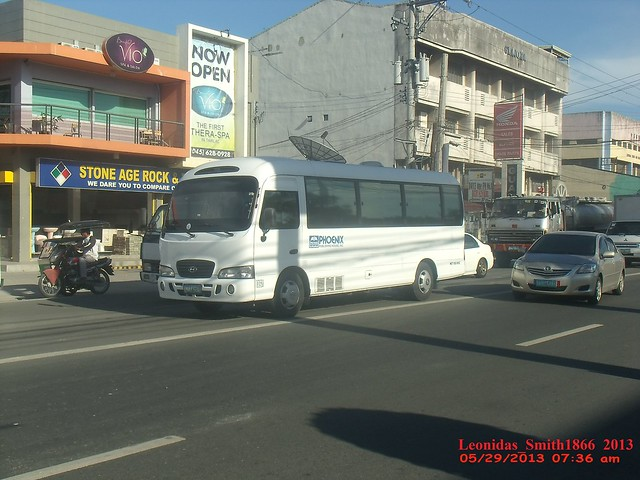

In [12]:
image = Image.open(filepath)
image

In [13]:
text = "car. bus. motorcycle. red advertisement billboard."

Generated 7 detections with 3 masks each


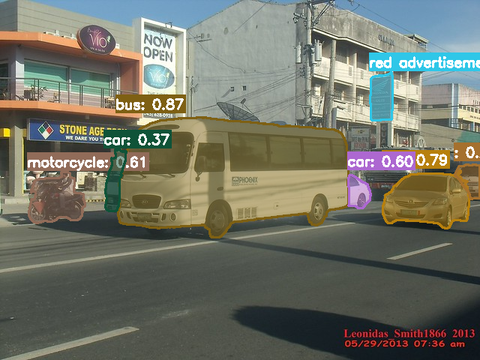

In [14]:
result_image = segment_with_grounded_sam(
    image=image,
    text_prompt=text,
    dino_model=dino_model,
    dino_processor=dino_processor,
    sam_model=sam_model,
    sam_processor=sam_processor,
    device=device,
    detection_threshold=0.25,
    text_threshold=0.3,
    refine_masks=True
)
result_image

## Video Segmentation

### Display Utils

In [15]:
# @title
def annotate(image: Union[Image.Image, np.ndarray], detection_results: List[DetectionResult]) -> np.ndarray:
    image_cv2 = np.array(image) if isinstance(image, Image.Image) else image
    image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_RGB2BGR)

    for detection in detection_results:
        label = detection.label
        score = detection.score
        box = detection.box
        mask = detection.mask

        color = np.random.randint(0, 256, size=3)

        cv2.rectangle(image_cv2, (box.xmin, box.ymin), (box.xmax, box.ymax), color.tolist(), 2)
        cv2.putText(image_cv2, f'{label}: {score:.2f}', (box.xmin, box.ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 2)

        if mask is not None:
            mask_uint8 = (mask * 255).astype(np.uint8)
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image_cv2, contours, -1, color.tolist(), 2)

    return cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

def plot_detections(
    image: Union[Image.Image, np.ndarray],
    detections: List[DetectionResult],
    save_name: Optional[str] = None
) -> None:
    annotated_image = annotate(image, detections)
    plt.imshow(annotated_image)
    plt.axis('off')
    if save_name:
        plt.savefig(save_name, bbox_inches='tight')
    plt.show()

In [16]:
# @title
def render_video_masks(
    video_frames: List[np.ndarray],
    video_segments: List[torch.Tensor],
    detection_results: List[DetectionResult],
    output_path: str = None,
    fps: int = 24,
    refine: bool = True,
    display_video: bool = True
) -> str:


    if len(video_frames) != len(video_segments):
        print(f"Warning: Frame count mismatch. Frames: {len(video_frames)}, Segments: {len(video_segments)}")
        min_length = min(len(video_frames), len(video_segments))
        video_frames = video_frames[:min_length]
        video_segments = video_segments[:min_length]

    if output_path is None:
        output_path = os.path.join(CWD, "segmented_video.mp4")

    temp_path = output_path.replace(".mp4", "_temp.mp4")
    height, width = video_frames[0].shape[:2]

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # MP4 codec
    out = cv2.VideoWriter(temp_path, fourcc, fps, (width, height))

    if not out.isOpened():
        raise RuntimeError(f"Failed to create video writer at {output_path}")

    print(f"Processing {len(video_frames)} frames...")

    np.random.seed(42)
    object_colors = [np.random.randint(0, 256, size=3).tolist()
                     for _ in range(len(detection_results))]

    pbar = tqdm(enumerate(zip(video_frames, video_segments)), total=len(video_frames), desc="Rendering frames")
    for frame_idx, (frame, masks_tensor) in pbar:
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        overlay = frame_bgr.copy()

        # masks_tensor -> num_objects,1,H,W
        if masks_tensor.dim() == 4:
            masks_tensor = torch.squeeze(masks_tensor, dim=1)
        # masks_tensor -> num_objects,H,W

        num_objects = masks_tensor.shape[0]

        for obj_idx in range(min(num_objects, len(detection_results))):
            mask = masks_tensor[obj_idx]  # Shape: [H, W]

            mask_np = mask.cpu().float().numpy()

            detection = detection_results[obj_idx]

            if refine:
                mask_binary = refine_mask(
                    mask_np,
                    use_morphology=True,
                    use_polygon_refinement=True,
                    min_contour_area=100
                )
            else:
                mask_binary = (mask_np > 0).astype(np.uint8) * 255

            color = object_colors[obj_idx]

            mask_bool = mask_binary == 255
            for c in range(3):
                overlay[:, :, c] = np.where(
                    mask_bool,
                    overlay[:, :, c] * 0.5 + color[c] * 0.5,
                    overlay[:, :, c]
                )

            contours, _ = cv2.findContours(
                mask_binary,
                cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE
            )

            if contours:
                cv2.drawContours(overlay, contours, -1, color, 2)

            if frame_idx % 10 == 0:
                label = detection.label
                score = detection.score
                box = detection.box

                text = f'{label}: {score:.2f}'
                text_position = (
                    box.xmin,
                    box.ymin - 10 if box.ymin - 10 > 0 else box.ymin + 20
                )

                (text_width, text_height), _ = cv2.getTextSize(
                    text,
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6,
                    2
                )
                cv2.rectangle(
                    overlay,
                    (text_position[0], text_position[1] - text_height - 5),
                    (text_position[0] + text_width, text_position[1] + 5),
                    color,
                    -1
                )
                cv2.putText(
                    overlay,
                    text,
                    text_position,
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6,
                    (255, 255, 255),
                    2
                )

        out.write(overlay)

    out.release()

    # FFMPEG RE-ENCODE
    print("\nRe-encoding video...")
    os.system(f"ffmpeg -y -loglevel error -i {temp_path} -c:v libx264 -vf format=yuv420p {output_path} >/dev/null 2>&1")
    os.remove(temp_path)

    print(f"\nVideo saved to: {output_path}")
    print(f"Video duration: {len(video_frames) / fps:.2f} seconds")

    if display_video:
        print("Displaying video:")
        display(Video(output_path, embed=True))

    return output_path

### Load Models

In [17]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from transformers import Sam2VideoModel, Sam2VideoProcessor

In [18]:
dino_model_id = "IDEA-Research/grounding-dino-base"
sam_model_id = "facebook/sam2.1-hiera-small"

In [19]:
dino_processor = AutoProcessor.from_pretrained(dino_model_id)
dino_model = AutoModelForZeroShotObjectDetection.from_pretrained(dino_model_id).to(device)

video_sam_model = Sam2VideoModel.from_pretrained(sam_model_id).to(device, dtype=torch.bfloat16)
video_sam_processor = Sam2VideoProcessor.from_pretrained(sam_model_id)

video_preprocessor_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

In [20]:
filename = os.path.join(CWD, "sample_video.mp4")
video_url = "https://drive.google.com/uc?export=download&id=1tm3y3w33nvo7ZDKsqXocYrjVGniYZtUT"
with requests.get(video_url, stream=True) as r:
    r.raise_for_status()
    with open(filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024*1024):
            if chunk:
                f.write(chunk)
print(filename)

/content/sample_video.mp4


In [21]:
# display(Video(filename=str(filename),embed=True))

In [22]:
cap = cv2.VideoCapture(filename)
original_fps = cap.get(cv2.CAP_PROP_FPS)
skip_interval = 2

OUTPUT_VIDEO_FPS = original_fps // skip_interval

video_frames = []
i = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    if i % skip_interval == 0:
        video_frames.append(frame)
    i += 1

cap.release()
video_frames = [cv2.cvtColor(f, cv2.COLOR_BGR2RGB) for f in video_frames]

### Video Segmentation Pipeline

In [23]:
inference_session = video_sam_processor.init_video_session(
    video=video_frames,
    inference_device=device,
    dtype=torch.bfloat16,
)

#### **Only Use videos less than 25s(24fps); 500 frames at max.**
This is done to avoid OutOfMemory Error in GPU.

In [24]:
# Add boxes on first frame to select object
ann_frame_idx = 0
image = video_frames[ann_frame_idx]
text_prompt = "a boy. a ball."

In [25]:
inputs = dino_processor(images=image, text=text_prompt, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = dino_model(**inputs)

results = dino_processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    threshold=0.3,
    text_threshold=0.3,
    target_sizes=[image.shape]
)

detection_results = DetectionResult.from_dict(results[0])

if not detection_results:
    print("No objects detected")

input_boxes = [obj.box.xyxy for obj in detection_results]

In [26]:
obj_ids = list(range(len(detection_results)))

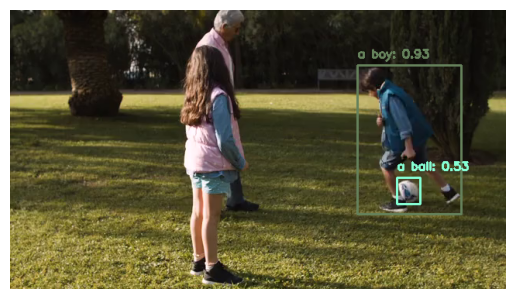

In [27]:
plot_detections(image=image,detections=detection_results)

In [28]:
input_boxes

[[448, 71, 582, 263], [499, 216, 529, 250]]

In [29]:
for obj_id, box in zip(obj_ids, input_boxes):
    video_sam_processor.add_inputs_to_inference_session(
        inference_session=inference_session,
        frame_idx=ann_frame_idx,
        obj_ids=[obj_id],
        input_boxes=[[box]],
    )
    _ = video_sam_model(
        inference_session=inference_session,
        frame_idx=ann_frame_idx,
    )

In [30]:
video_segments = []
for sam2_video_output in video_sam_model.propagate_in_video_iterator(inference_session):
    video_res_masks = video_sam_processor.post_process_masks(
        [sam2_video_output.pred_masks], original_sizes=[[inference_session.video_height, inference_session.video_width]], binarize=True
    )[0]
    video_segments.append(video_res_masks)

print(f"Tracked object through {len(video_segments)} frames")

propagate in video: 100%|██████████| 192/192 [02:10<00:00,  1.47it/s]

Tracked object through 192 frames


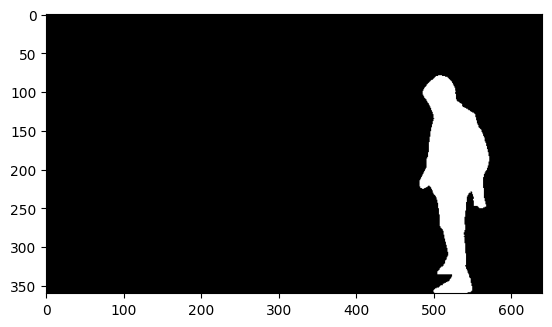

In [31]:
plt.imshow((video_segments[100][0].squeeze()).cpu().float().numpy(),cmap='grey')

In [32]:
rendered_video_path = render_video_masks(
    video_frames=video_frames,
    video_segments=video_segments,
    detection_results=detection_results,
    display_video = True,
    fps = OUTPUT_VIDEO_FPS
)

Processing 192 frames...


Rendering frames: 100%|██████████| 192/192 [00:02<00:00, 68.38it/s]



Re-encoding video...

Video saved to: /content/segmented_video.mp4
Video duration: 16.00 seconds
Displaying video:
